# Double DQN on Gridworld Environment

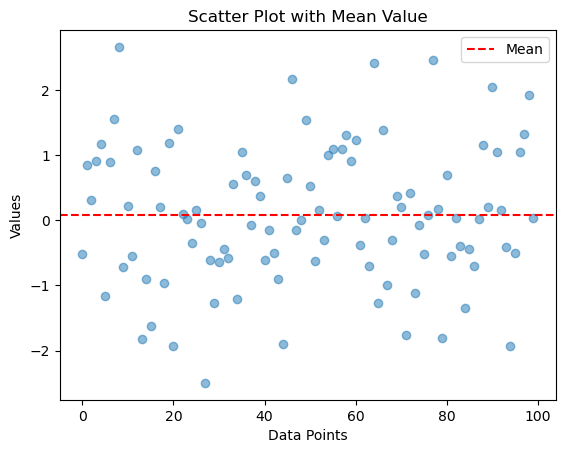

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = np.random.randn(100)

# Calculate the mean value
mean_value = np.mean(data)

# Plot the data with alpha level
plt.scatter(range(len(data)), data, alpha=0.5)

# Add a horizontal line for the mean value
plt.axhline(mean_value, color='red', linestyle='--', label='Mean')

# Set plot properties
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Scatter Plot with Mean Value')
plt.legend()

# Display the plot
plt.show()

## Define test_model

In [2]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size=4, mode=mode) #產生一場測試遊戲
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
      print("Initial State:")
      print(test_game.display())
    status = 1
    while(status == 1): #遊戲仍在進行
      qval = model(state)
      qval_ = qval.data.numpy()
      action_ = np.argmax(qval_) 
      action = action_set[action_]
      if display:
        print('Move #: %s; Taking action: %s' % (i, action))
      test_game.makeMove(action)
      state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
      state = torch.from_numpy(state_).float()
      if display:
        print(test_game.display())
      reward = test_game.reward()
      if reward != -1: #代表勝利（抵達終點）或落敗（掉入陷阱）
        if reward > 0: #reward>0，代表成功抵達終點
          status = 2 #將狀態設為2，跳出迴圈
          if display:
            print("Game won! Reward: %s" %reward)
          else: #掉入陷阱
            status = 0 #將狀態設為0，跳出迴圈
            if display:
              print("Game LOST. Reward: %s" %reward)
      i += 1 #每移動一步，i就加1
      if (i > 15): #若移動了15步，仍未取出勝利，則一樣視為落敗
        if display:
          print("Game lost; too many moves.")
        break    
    win = True if status == 2 else False
    print(win)
    return win

# Double DQN

## Static mode


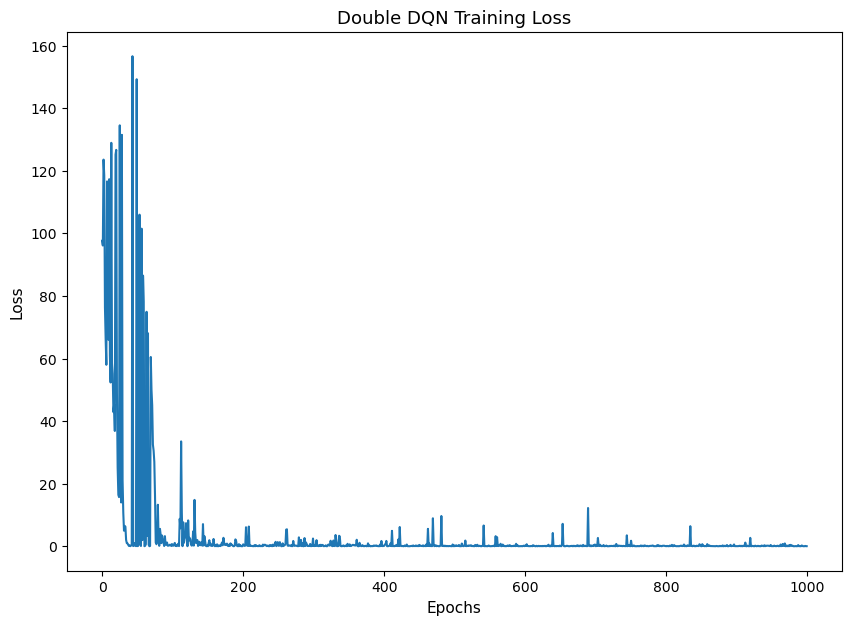

In [3]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
import copy

# 網路設定
L1 = 64
L2 = 150
L3 = 100
L4 = 4

# 定義主網路（online network）
model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3),
    torch.nn.ReLU(),
    torch.nn.Linear(L3, L4)
)

# 定義目標網路（target network），初始是主網路的拷貝
target_model = copy.deepcopy(model)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r'
}

epochs = 1000
losses = []
target_update_freq = 10  # 每 10 次更新一次 target network

for i in range(epochs):
    game = Gridworld(size=4, mode='static')
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state1 = torch.from_numpy(state_).float()
    status = 1
    
    while status == 1:
        qval = model(state1)
        qval_ = qval.data.numpy()

        # epsilon-greedy 策略選動作
        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)
        
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()

        with torch.no_grad():
            # Double DQN 部分
            next_qvals_online = model(state2.reshape(1, 64))  # 用 online model 選動作
            best_action = torch.argmax(next_qvals_online).item()

            next_qvals_target = target_model(state2.reshape(1, 64))  # 用 target model 評估
            maxQ = next_qvals_target.squeeze()[best_action]

        if reward == -1:
            Y = reward + (gamma * maxQ)
        else:
            Y = reward

        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_]

        loss = loss_fn(X, Y)

        if i % 100 == 0:
            print(i, loss.item())
            clear_output(wait=True)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state1 = state2

        if abs(reward) == 10:
            status = 0

    losses.append(loss.item())

    # 更新 epsilon
    if epsilon > 0.1:
        epsilon -= (1/epochs)

    # 每隔 target_update_freq 更新 target_model
    if i % target_update_freq == 0:
        target_model.load_state_dict(model.state_dict())

# 儲存訓練完的模型
torch.save(model.state_dict(), 'double_dqn_static_model.pth')

# 畫出 loss 曲線
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel("Epochs", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.title("Double DQN Training Loss", fontsize=13)
plt.show()


## Static mode testing

In [4]:
# 載入訓練過的模型
model.load_state_dict(torch.load('double_dqn_static_model.pth'))
model.eval()

max_games = 1000 #模擬1000次遊戲
wins = 0
for i in range(max_games):
  win = test_model(model, mode='static') #利用random模式來進行測試
  if win:
    wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率


C:\Users\raced\AppData\Local\Temp\ipykernel_11876\2559206342.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('double_dqn_static_model.pt

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True
Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W

## Player mode

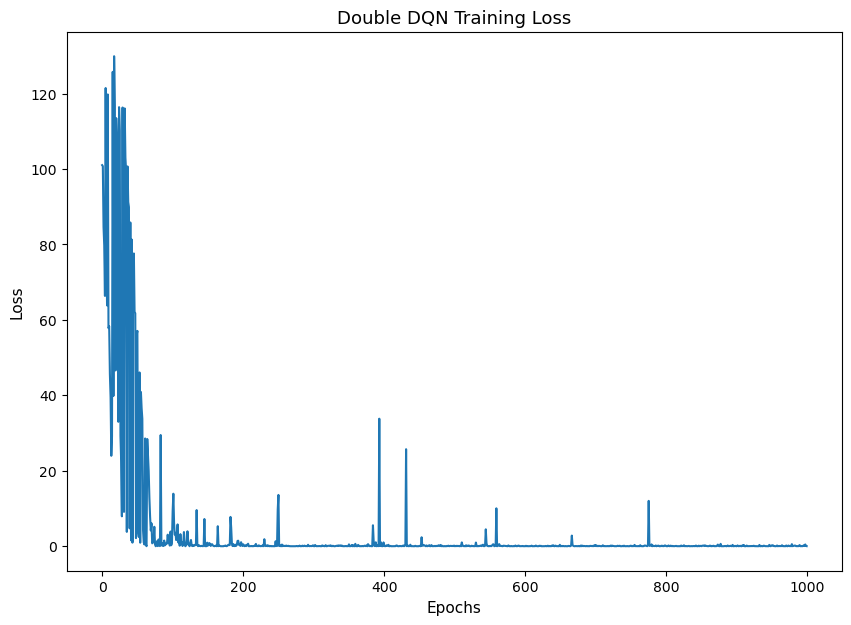

In [5]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
import copy

# 網路設定
L1 = 64
L2 = 150
L3 = 100
L4 = 4

# 定義主網路（online network）
model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3),
    torch.nn.ReLU(),
    torch.nn.Linear(L3, L4)
)

# 定義目標網路（target network），初始是主網路的拷貝
target_model = copy.deepcopy(model)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r'
}

epochs = 1000
losses = []
target_update_freq = 10  # 每 10 次更新一次 target network

for i in range(epochs):
    game = Gridworld(size=4, mode='player')
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state1 = torch.from_numpy(state_).float()
    status = 1
    
    while status == 1:
        qval = model(state1)
        qval_ = qval.data.numpy()

        # epsilon-greedy 策略選動作
        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)
        
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()

        with torch.no_grad():
            # Double DQN 部分
            next_qvals_online = model(state2.reshape(1, 64))  # 用 online model 選動作
            best_action = torch.argmax(next_qvals_online).item()

            next_qvals_target = target_model(state2.reshape(1, 64))  # 用 target model 評估
            maxQ = next_qvals_target.squeeze()[best_action]

        if reward == -1:
            Y = reward + (gamma * maxQ)
        else:
            Y = reward

        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_]

        loss = loss_fn(X, Y)

        if i % 100 == 0:
            print(i, loss.item())
            clear_output(wait=True)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state1 = state2

        if abs(reward) == 10:
            status = 0

    losses.append(loss.item())

    # 更新 epsilon
    if epsilon > 0.1:
        epsilon -= (1/epochs)

    # 每隔 target_update_freq 更新 target_model
    if i % target_update_freq == 0:
        target_model.load_state_dict(model.state_dict())

# 儲存訓練完的模型
torch.save(model.state_dict(), 'double_dqn_player_model.pth')

# 畫出 loss 曲線
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel("Epochs", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.title("Double DQN Training Loss", fontsize=13)
plt.show()


## Player mode testing

In [6]:
# 載入訓練過的模型
model.load_state_dict(torch.load('double_dqn_player_model.pth'))
model.eval()

max_games = 1000 #模擬1000次遊戲
wins = 0
for i in range(max_games):
  win = test_model(model, mode='player') #利用random模式來進行測試
  if win:
    wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

C:\Users\raced\AppData\Local\Temp\ipykernel_11876\1115116728.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('double_dqn_player_model.pt

Initial State:
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True
Initial State:
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W

## Random mode 

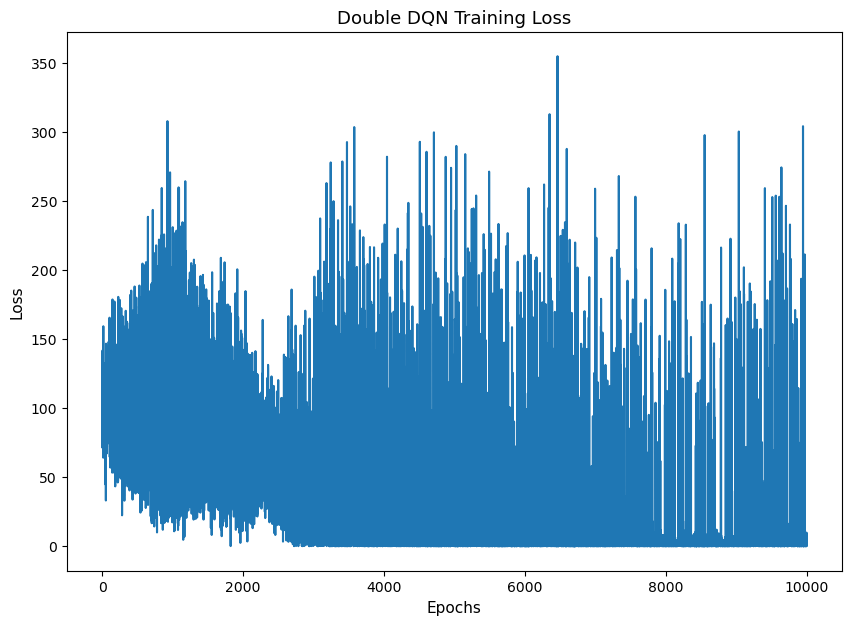

In [7]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
import copy

# 網路設定
L1 = 64
L2 = 150
L3 = 100
L4 = 4

# 定義主網路（online network）
model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3),
    torch.nn.ReLU(),
    torch.nn.Linear(L3, L4)
)

# 定義目標網路（target network），初始是主網路的拷貝
target_model = copy.deepcopy(model)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r'
}

epochs = 10000
losses = []
target_update_freq = 100  # 每 100 次更新一次 target network

for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state1 = torch.from_numpy(state_).float()
    status = 1
    
    while status == 1:
        qval = model(state1)
        qval_ = qval.data.numpy()

        # epsilon-greedy 策略選動作
        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)
        
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()

        with torch.no_grad():
            # Double DQN 部分
            next_qvals_online = model(state2.reshape(1, 64))  # 用 online model 選動作
            best_action = torch.argmax(next_qvals_online).item()

            next_qvals_target = target_model(state2.reshape(1, 64))  # 用 target model 評估
            maxQ = next_qvals_target.squeeze()[best_action]

        if abs(reward) == 10:  # 遊戲結束時
            Y = reward
        else:
            Y = reward + (gamma * maxQ)

        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_]

        loss = loss_fn(X, Y)

        if i % 100 == 0:
            print(i, loss.item())
            clear_output(wait=True)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state1 = state2

        if abs(reward) == 10:
            status = 0

    losses.append(loss.item())

    # 更新 epsilon
    if epsilon > 0.1:
        epsilon -= (1/epochs)

    # 每隔 target_update_freq 更新 target_model
    if i % target_update_freq == 0:
        target_model.load_state_dict(model.state_dict())

# 儲存訓練完的模型
torch.save(model.state_dict(), 'double_dqn_random_model.pth')

# 畫出 loss 曲線
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel("Epochs", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.title("Double DQN Training Loss", fontsize=13)
plt.show()


## Random mode testing

In [8]:
# 載入訓練過的模型
model.load_state_dict(torch.load('double_dqn_random_model.pth'))
model.eval()

max_games = 1000 #模擬1000次遊戲
wins = 0
for i in range(max_games):
  win = test_model(model, mode='random') #利用random模式來進行測試
  if win:
    wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

C:\Users\raced\AppData\Local\Temp\ipykernel_11876\2634649134.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('double_dqn_random_model.pt

Initial State:
[[' ' ' ' ' ' ' ']
 [' ' 'P' ' ' ' ']
 ['-' '+' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Move #: 0; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['-' '+' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Game won! Reward: 10
True
Initial State:
[['W' ' ' 'P' '-']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['W' ' ' ' ' '-']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True
Initial State:
[[' ' ' ' 'W' '-']
 [' ' ' ' ' ' '+']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: r
[[' ' ' ' 'W' '-']
 [' ' ' ' ' ' '+']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: r
[[' ' ' ' 'W' '-']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: u
[[' ' ' ' 'W' '-']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True
Initial State:
[[' ' '-' ' ' ' ']
 [' ' ' ' 'W' '+']
 [' ' ' ' ' ' ' ']
 [' ' 'P' ' ' ' ']]
Move #: 0; Taking action: u
[